<a href="https://colab.research.google.com/github/berilldindar/Pneumonia-Detection-/blob/main/PneumoniaDetectionVGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras.layers import  Flatten,Dense
from keras.models import Sequential

import glob, os, random

In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os
import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from keras.models import Model, load_model
from keras.layers import Dense, Input, Conv2D, MaxPool2D, Flatten
from keras.preprocessing.image import ImageDataGenerator
np.random.seed(22)

In [ ]:
def load_normal(norm_path):
    norm_files = np.array(os.listdir(norm_path))
    norm_labels = np.array(['normal']*len(norm_files))
    
    norm_images = []
    for image in tqdm(norm_files):
        image = cv2.imread(norm_path + image)
        image = cv2.resize(image, dsize=(48,48))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        norm_images.append(image)
        
    norm_images = np.array(norm_images)
    
    return norm_images, norm_labels
def load_pneumonia(pneu_path):
    pneu_files = np.array(os.listdir(pneu_path))
    pneu_labels = np.array([pneu_file.split('_')[1] for pneu_file in pneu_files])
    
    pneu_images = []
    for image in tqdm(pneu_files):
        image = cv2.imread(pneu_path + image)
        image = cv2.resize(image, dsize=(48,48))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        pneu_images.append(image)
        
    pneu_images = np.array(pneu_images)
    
    return pneu_images, pneu_labels

In [ ]:
norm_images, norm_labels = load_normal('/content/drive/MyDrive/FinalOdevDerin/train/NORMAL/')
pneu_images, pneu_labels = load_pneumonia('/content/drive/MyDrive/FinalOdevDerin/train/PNEUMONIA/')

100%|██████████| 3883/3883 [00:57<00:00, 67.69it/s]


In [ ]:
X_train = np.append(norm_images, pneu_images, axis=0)
y_train = np.append(norm_labels, pneu_labels)

In [ ]:
np.unique(y_train,return_counts=True)
#OpenCV'nin görüntüyü okuduğu varsayılan dtype 'uint8' olduğundan, bu görüntü üzerinde çalışan her şeyin uyumluluk için 'uint8' türünde olması gerekir.

(array(['bacteria', 'normal', 'virus'], dtype='<U8'),
 array([2538, 1349, 1345]))

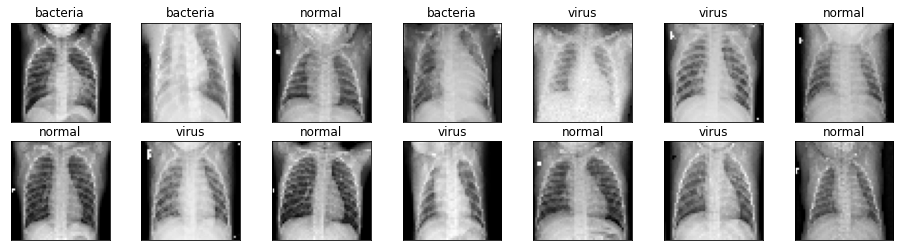

In [ ]:
fig, axes = plt.subplots(ncols=7, nrows=2, figsize=(16, 4))

indices = np.random.choice(len(X_train), 14)
counter = 0


for i in range(2):
    for j in range(7):
        axes[i,j].set_title(y_train[indices[counter]])
        axes[i,j].imshow(X_train[indices[counter]], cmap='gray')
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        counter += 1
plt.show()

In [ ]:
norm_images_test, norm_labels_test = load_normal('/content/drive/MyDrive/FinalOdevDerin/test/NORMAL/')
pneu_images_test, pneu_labels_test = load_pneumonia('/content/drive/MyDrive/FinalOdevDerin/test/PNEUMONIA/')
X_test = np.append(norm_images_test, pneu_images_test, axis=0)
y_test = np.append(norm_labels_test, pneu_labels_test)

100%|██████████| 390/390 [00:05<00:00, 74.59it/s]


In [ ]:
with open('pneumonia_data.pickle', 'wb') as f:
    pickle.dump((X_train, X_test, y_train, y_test), f)
with open('pneumonia_data.pickle', 'rb') as f:
    (X_train, X_test, y_train, y_test) = pickle.load(f)

In [ ]:
y_train = y_train[:, np.newaxis]
y_test = y_test[:, np.newaxis]

In [ ]:
one_hot_encoder = OneHotEncoder(sparse=False)

In [ ]:
y_train_one_hot = one_hot_encoder.fit_transform(y_train)
y_test_one_hot = one_hot_encoder.transform(y_test)

In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

In [ ]:
datagen = ImageDataGenerator(
        rotation_range = 10,  
        zoom_range = 0.1, 
        width_shift_range = 0.1,
        validation_split=0.1, 
        height_shift_range = 0.1)

In [ ]:
datagen.fit(X_train)
train_gen = datagen.flow(X_train, y_train_one_hot, batch_size = 32)

In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2], 1)
print(input_shape)

(48, 48, 1)


In [ ]:
from keras.applications.vgg16 import VGG16
vgg_conv = VGG16(weights=None, include_top=False, input_shape=(48, 48,1))

vgg_model = Sequential()
vgg_model.add(vgg_conv)

vgg_model.add(Flatten())
vgg_model.add(Dense(3,  kernel_initializer='normal', activation='softmax'))
vgg_model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
vgg_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14713536  
_________________________________________________________________
flatten_3 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 1539      
Total params: 14,715,075
Trainable params: 14,715,075
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(vgg_model, to_file='model.png')

In [ ]:
history = vgg_model.fit(train_gen, epochs=30, 
          validation_data=(X_test, y_test_one_hot))

Epoch 1/30
164/164 [==============================] - 647s 4s/step - loss: 2.6026 - accuracy: 0.4883 - val_loss: 1.0342 - val_accuracy: 0.5192
Epoch 2/30
164/164 [==============================] - 617s 4s/step - loss: 0.9312 - accuracy: 0.5471 - val_loss: 0.9822 - val_accuracy: 0.5881
Epoch 3/30
164/164 [==============================] - 623s 4s/step - loss: 0.9007 - accuracy: 0.5657 - val_loss: 0.9850 - val_accuracy: 0.5865
Epoch 4/30
164/164 [==============================] - 632s 4s/step - loss: 0.8811 - accuracy: 0.6005 - val_loss: 0.9716 - val_accuracy: 0.6138
Epoch 5/30
164/164 [==============================] - 631s 4s/step - loss: 0.8939 - accuracy: 0.5867 - val_loss: 0.9073 - val_accuracy: 0.6074
Epoch 6/30
164/164 [==============================] - 634s 4s/step - loss: 0.8701 - accuracy: 0.6078 - val_loss: 0.9844 - val_accuracy: 0.5962
Epoch 7/30
164/164 [==============================] - 627s 4s/step - loss: 0.8842 - accuracy: 0.5989 - val_loss: 0.9823 - val_accuracy: 0.5897

Displaying accuracy


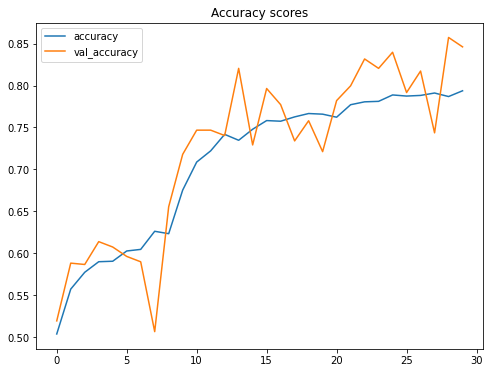

Displaying loss


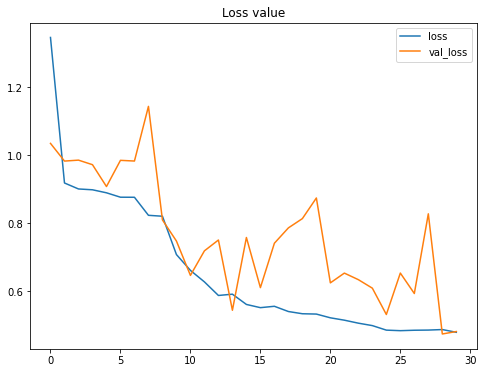

In [ ]:
print('Displaying accuracy')
plt.figure(figsize=(8,6))
plt.title('Accuracy scores')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()
print('Displaying loss')
plt.figure(figsize=(8,6))
plt.title('Loss value')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [ ]:
predictions = vgg_model.predict(X_test)
print(predictions)

[[0.23229088 0.49243602 0.27527317]
 [0.00245374 0.9946306  0.00291556]
 [0.01533425 0.96178955 0.02287626]
 ...
 [0.2211145  0.00341282 0.77547264]
 [0.1694909  0.14684492 0.68366426]
 [0.28252965 0.04990211 0.66756827]]


In [ ]:
predictions = one_hot_encoder.inverse_transform(predictions)

In [ ]:
print('Model evaluation')
print(one_hot_encoder.categories_)

classnames = ['bacteria', 'normal', 'virus']

Model evaluation
[array(['bacteria', 'normal', 'virus'], dtype='<U8')]


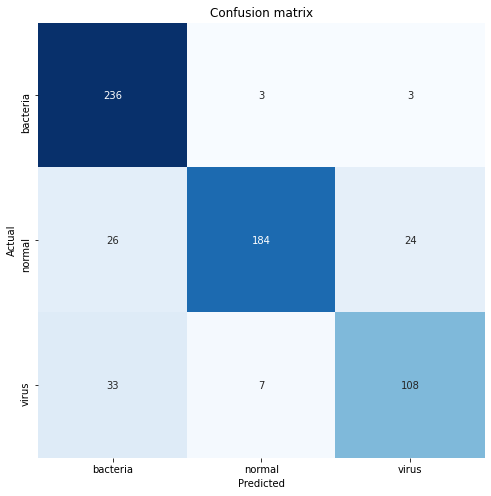

In [ ]:
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8,8))
plt.title('Confusion matrix')
sns.heatmap(cm, cbar=False, xticklabels=classnames, yticklabels=classnames, fmt='d', annot=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
print('Classification Report')
target_names = ['normal',  'bacteria',  'virus']
print(classification_report(y_test,predictions, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

      normal       0.80      0.98      0.88       242
    bacteria       0.95      0.79      0.86       234
       virus       0.80      0.73      0.76       148

    accuracy                           0.85       624
   macro avg       0.85      0.83      0.83       624
weighted avg       0.86      0.85      0.84       624

